# Making Predictions

## Combining Data

In [ ]:
import pandas as pd
import yfinance as yf

#Economic Data
series_ids = {
    'GDP': 'GDP',
    'Federal Funds': 'FEDFUNDS',
    'Unemployment Rate': 'UNRATE',
    'Consumer Price Index (CPI)': 'CPIAUCSL',
    'Producer Price Index (PPI)': 'PPIACO'
}
start_date = '2023-01-01'
end_date = '2023-12-15'

data = {}
for series_name, series_id in series_ids.items():
    data[series_name] = fred.get_series(series_id, observation_start=start_date, observation_end=end_date)

economic_data = pd.DataFrame(data)

# datetime index
economic_data.index = pd.to_datetime(economic_data.index)

# SPY Data
spy_data = yf.download('SPY', start=start_date, end=end_date)

# Use'Close' price of SPY
spy_data = spy_data[['Close']]

# Combine the economic data and SPY data
combined_data = economic_data.join(spy_data, how='outer')

combined_data['GDP'] = combined_data['GDP'].fillna(method='ffill')
combined_data['Federal Funds'] = combined_data['Federal Funds'].fillna(method='ffill')
combined_data['Unemployment Rate'] = combined_data['Unemployment Rate'].fillna(method='ffill')
combined_data['Consumer Price Index (CPI)'] = combined_data['Consumer Price Index (CPI)'].fillna(method='ffill')
combined_data['Producer Price Index (PPI)'] = combined_data['Producer Price Index (PPI)'].fillna(method='ffill')
combined_data = combined_data.dropna(subset=['Close'])

# Print
combined_data

[*********************100%%**********************]  1 of 1 completed


,GDP,Federal Funds,Unemployment Rate,Consumer Price Index (CPI),Producer Price Index (PPI),Close
2023-01-03,26813.601,4.33,3.4,300.536,260.227,380.820007
2023-01-04,26813.601,4.33,3.4,300.536,260.227,383.760010
2023-01-05,26813.601,4.33,3.4,300.536,260.227,379.380005
2023-01-06,26813.601,4.33,3.4,300.536,260.227,388.079987
2023-01-09,26813.601,4.33,3.4,300.536,260.227,387.859985
...,...,...,...,...,...,...
2023-12-08,27644.463,5.33,3.7,307.917,253.811,460.200012
2023-12-11,27644.463,5.33,3.7,307.917,253.811,461.989990
2023-12-12,27644.463,5.33,3.7,307.917,253.811,464.100006
2023-12-13,27644.463,5.33,3.7,307.917,253.811,470.500000


## Analysis

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

combined_data = combined_data

# Calculate the rates of change for all the economic factors
factors = ['GDP', 'Federal Funds', 'Unemployment Rate', 'Consumer Price Index (CPI)', 'Producer Price Index (PPI)']
for factor in factors:
    combined_data[f'{factor} Change'] = combined_data[factor].pct_change()

# Calculate the rate of change for the SPY close price
combined_data['Close Change'] = combined_data['Close'].pct_change()

# Drop the initial row with NaN
combined_data = combined_data.dropna()

# Correlation Analysis
# Print the correlation coefficients
for factor in factors:
    correlation_original = combined_data[factor].corr(combined_data['Close'])
    correlation_change = combined_data[f'{factor} Change'].corr(combined_data['Close Change'])
    print(f"Correlation Coefficient (Original) for {factor}: {correlation_original}")
    print(f"Correlation Coefficient (Change) for {factor}: {correlation_change}")

# Regression Analysis for the original values
X = combined_data[factors]  # Independent variables
Y = combined_data['Close']  # Dependent variable
X = sm.add_constant(X)  # Add a constant to the independent variables
model = sm.OLS(Y, X).fit()  # Fit the regression model
print(model.summary())

Correlation Coefficient (Original) for GDP: 0.8400041636986875
Correlation Coefficient (Change) for GDP: 0.010407449019498879
Correlation Coefficient (Original) for Federal Funds: 0.8155798385621941
Correlation Coefficient (Change) for Federal Funds: 0.02917854756280671
Correlation Coefficient (Original) for Unemployment Rate: 0.4882332904832733
Correlation Coefficient (Change) for Unemployment Rate: -0.0316829641936408
Correlation Coefficient (Original) for Consumer Price Index (CPI): 0.7740695762046287
Correlation Coefficient (Change) for Consumer Price Index (CPI): 0.03752803187425529
Correlation Coefficient (Original) for Producer Price Index (PPI): -0.4622789208372443
Correlation Coefficient (Change) for Producer Price Index (PPI): -0.02308995858004873
                            OLS Regression Results                            
Dep. Variable:                  Close   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0

# Part I: Prediction 1/1/23~12/15/23

## Feature Engineering

In [ ]:
#Feature Engineering
# Calculate Moving Averages for the 'Close' price
spy_data['20_day_MA'] = spy_data['Close'].rolling(window=20).mean()
spy_data['50_day_MA'] = spy_data['Close'].rolling(window=50).mean()


# Calculate the Exponential Moving Average (EMA) for a span of 20 days
spy_data['20_day_EMA'] = spy_data['Close'].ewm(span=20, adjust=False).mean()

# Combine these new features into the existing combined_data DataFrame
combined_data = combined_data.join(spy_data[['20_day_MA','50_day_MA','20_day_EMA']], how='outer')

# Drop any rows with NaN
combined_data.dropna(inplace=True)


from sklearn.preprocessing import MinMaxScaler

# Initialize a scaler
close_scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler on your 'Close' prices and other features to be scaled
features_to_scale = factors + ['Close', '20_day_MA','50_day_MA', '20_day_EMA']
# Fit the scaler on the features and transform them
combined_data[features_to_scale] = close_scaler.fit_transform(combined_data[features_to_scale])

<ipython-input-5-149737a28a6b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy_data['20_day_MA'] = spy_data['Close'].rolling(window=20).mean()
<ipython-input-5-149737a28a6b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spy_data['50_day_MA'] = spy_data['Close'].rolling(window=50).mean()
<ipython-input-5-149737a28a6b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

## Preparing Data for LSTM

In [ ]:
#Preparing Data for LSTM
import numpy as np

# Define the sequence length
sequence_length = 5

# Function to create sequences
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)].to_numpy()  # Contains the features
        y = data.iloc[i + seq_length]['Close']  # Contains the 'Close' price
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

# Create sequences
X, y = create_sequences(combined_data[features_to_scale], sequence_length)

# Split the data into training and test sets (80/20 split)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


## Hyperparameter Tuning

In [ ]:
pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.8 MB/s eta 0:00:00


In [ ]:
#Hyperparameter Tuning

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from kerastuner.tuners import RandomSearch

def build_model(hp):
    model = Sequential()
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32),
                   return_sequences=True,
                   input_shape=(sequence_length, len(features_to_scale))))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), return_sequences=False))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(units=1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5,  # Set the number of different hyperparameter combinations
    executions_per_trial=1,  # Number of models to train for each trial
    directory='my_dir',  # Directory to save logs and models
    project_name='lstm_tuning'
)

tuner.search_space_summary()

tuner.search(X_train, y_train,
             epochs=10,  # Use 10 epochs
             batch_size=32,  # 32 batch sizes
             validation_data=(X_test, y_test))

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first LSTM layer is {best_hps.get('units')}
and the optimal dropout rates are {best_hps.get('dropout_1')} and {best_hps.get('dropout_2')}.
""")

# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train,
                    epochs=50,  # 50 Epochs
                    batch_size=32,
                    validation_data=(X_test, y_test))


Trial 5 Complete [00h 00m 05s]
val_loss: 0.01023099571466446

Best val_loss So Far: 0.010050404816865921
Total elapsed time: 00h 00m 30s

The hyperparameter search is complete. The optimal number of units in the first LSTM layer is 480
and the optimal dropout rates are 0.2 and 0.4.

Epoch 1/50
5/5 [==============================] - 4s 186ms/step - loss: 0.1020 - val_loss: 0.1009
Epoch 2/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0579 - val_loss: 0.0282
Epoch 3/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0173 - val_loss: 0.0216
Epoch 4/50
5/5 [==============================] - 0s 13ms/step - loss: 0.0120 - val_loss: 0.0391
Epoch 5/50
5/5 [==============================] - 0s 16ms/step - loss: 0.0111 - val_loss: 0.0106
Epoch 6/50
5/5 [==============================] - 0s 17ms/step - loss: 0.0071 - val_loss: 0.0114
Epoch 7/50
5/5 [==============================] - 0s 16ms/step - loss: 0.0063 - val_loss: 0.0157
Epoch 8/50
5/5 [====================

# EarlyStopping

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitors the validation loss
    patience=10,         # Number of epochs to wait after min has been hit. After this number of no improvement, training stops
    verbose=1,
    restore_best_weights=True  # Restores model weights from the epoch with the best value of the monitored quantity
)


## Adding LAYERS

# L1 and L2 Regularization

In [ ]:
from tensorflow.keras.regularizers import l1, l2, l1_l2

model = Sequential()

# Input layer with L2 regularization
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, len(features_to_scale)),
               kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))

# Adding more LSTM layers with L2 regularization
model.add(LSTM(units=50, return_sequences=True, kernel_regularizer=l2(0.01)))  # Second LSTM layer
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True, kernel_regularizer=l2(0.01)))  # Third LSTM layer
model.add(Dropout(0.2))

# Final LSTM layer does not return sequences, add regularization here too
model.add(LSTM(units=50, return_sequences=False, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))

# Output layer with L1 regularization
model.add(Dense(units=1, kernel_regularizer=l1(0.01)))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(
    X_train, y_train,
    epochs=100,  # Adjust the number of epochs as needed
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

test_loss = model.evaluate(X_test, y_test, verbose=1)

Epoch 1/100
5/5 [==============================] - 8s 375ms/step - loss: 2.8377 - val_loss: 2.8090
Epoch 2/100
5/5 [==============================] - 0s 16ms/step - loss: 2.5389 - val_loss: 2.4730
Epoch 3/100
5/5 [==============================] - 0s 19ms/step - loss: 2.2510 - val_loss: 2.1398
Epoch 4/100
5/5 [==============================] - 0s 18ms/step - loss: 2.0031 - val_loss: 1.8969
Epoch 5/100
5/5 [==============================] - 0s 19ms/step - loss: 1.8254 - val_loss: 1.7224
Epoch 6/100
5/5 [==============================] - 0s 20ms/step - loss: 1.6493 - val_loss: 1.5754
Epoch 7/100
5/5 [==============================] - 0s 19ms/step - loss: 1.4915 - val_loss: 1.4448
Epoch 8/100
5/5 [==============================] - 0s 20ms/step - loss: 1.3549 - val_loss: 1.3053
Epoch 9/100
5/5 [==============================] - 0s 19ms/step - loss: 1.2245 - val_loss: 1.1748
Epoch 10/100
5/5 [==============================] - 0s 19ms/step - loss: 1.1081 - val_loss: 1.0613
Epoch 11/100
5/5 [

## Training, Evaluating and and Predictions LSTM Model

In [ ]:
#Training the LSTM Model
# Fit the model to the training data
history = model.fit(
    X_train, y_train,
    epochs=100,  # The number of epochs can be adjusted based on the training performance
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

#Evaluating the Model
test_loss = model.evaluate(X_test, y_test, verbose=1)
print(f'Test Loss: {test_loss}')

#Making Predictions
predictions = model.predict(X_test)

Epoch 1/100
5/5 [==============================] - 0s 23ms/step - loss: 0.0311 - val_loss: 0.0427
Epoch 2/100
5/5 [==============================] - 0s 14ms/step - loss: 0.0314 - val_loss: 0.0502
Epoch 3/100
5/5 [==============================] - 0s 14ms/step - loss: 0.0299 - val_loss: 0.0425
Epoch 4/100
5/5 [==============================] - 0s 14ms/step - loss: 0.0289 - val_loss: 0.0502
Epoch 5/100
5/5 [==============================] - 0s 14ms/step - loss: 0.0295 - val_loss: 0.0429
Epoch 6/100
5/5 [==============================] - 0s 14ms/step - loss: 0.0282 - val_loss: 0.0456
Epoch 7/100
5/5 [==============================] - 0s 14ms/step - loss: 0.0304 - val_loss: 0.0406
Epoch 8/100
5/5 [==============================] - 0s 14ms/step - loss: 0.0278 - val_loss: 0.0385
Epoch 9/100
5/5 [==============================] - 0s 14ms/step - loss: 0.0283 - val_loss: 0.0474
Epoch 10/100
5/5 [==============================] - 0s 14ms/step - loss: 0.0290 - val_loss: 0.0423
Epoch 11/100
5/5 [=

## Reshaping

In [ ]:
# y_test is reshaped to a 2D array
y_test_reshaped = y_test.reshape(-1, 1)

# Create a temporary array for y_test with the same shape as the scaled data
temp_y_test = np.zeros(shape=(y_test_reshaped.shape[0], len(features_to_scale)))

# Copy y_test data into the corresponding 'Close' column
temp_y_test[:, -1] = y_test_reshaped.ravel()

# Use the scaler to inverse transform this temporary array
y_test_rescaled = close_scaler.inverse_transform(temp_y_test)

# Extract the 'Close' prices column
y_test_rescaled = y_test_rescaled[:, -1]


#Rescale Predictions
# Ensure predictions are reshaped to a 2D array
predictions_reshaped = predictions.reshape(-1, 1)

# Create a temporary array for predictions with the same shape as the scaled data
temp_predictions = np.zeros(shape=(predictions_reshaped.shape[0], len(features_to_scale)))

# Copy predictions data into the corresponding 'Close' column
temp_predictions[:, -1] = predictions_reshaped.ravel()

# Use the scaler to inverse transform this temporary array
predictions_rescaled = close_scaler.inverse_transform(temp_predictions)

# Extract the 'Close' prices column (now inverse transformed)
predictions_rescaled = predictions_rescaled[:, -1]

dates = combined_data.index[-len(y_test):]

## Plot Prediction and Metrics

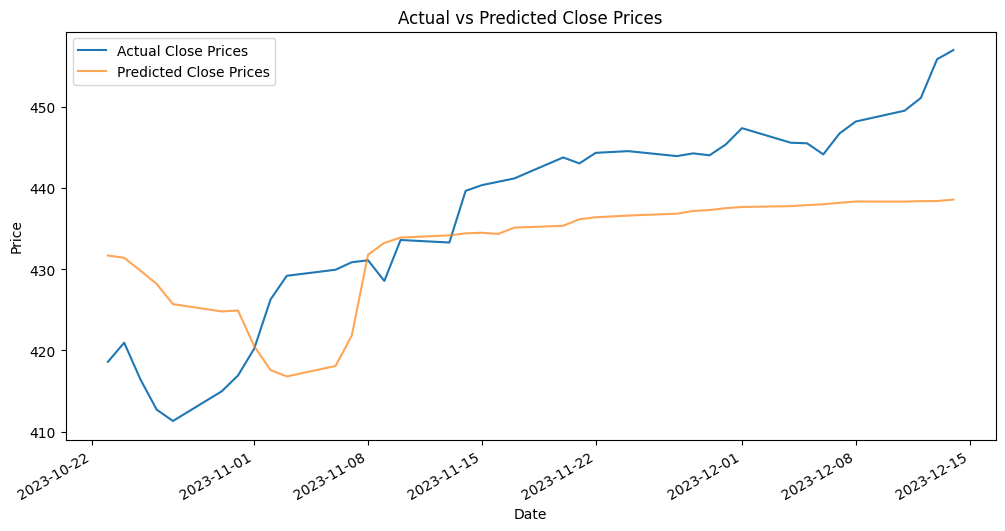

Mean Squared Error: 91.87344703944716
Mean Absolute Error: 8.597008708096414
R2 Score: 0.41100106758603694


In [ ]:
# Plot Prediction
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_rescaled, label='Actual Close Prices')
plt.plot(dates, predictions_rescaled, label='Predicted Close Prices', alpha=0.7)
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

#Calculate Performance Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
r2 = r2_score(y_test_rescaled, predictions_rescaled)

print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")
print(f"R2 Score: {r2}")

## Prediction Data Frame

In [ ]:
# Adjust the slice to match where your test data actually begins.
dates = combined_data.index[-len(y_test_rescaled):]

# Now create a DataFrame with the dates and actual and predicted prices
results_df = pd.DataFrame({
    'Date': dates,
    'Actual Price': y_test_rescaled.flatten(),
    'Predicted Price': predictions_rescaled.flatten()
})

#print
results_df

,Date,Actual Price,Predicted Price
0,2023-10-23,418.593020,431.699073
1,2023-10-24,420.956031,431.417314
2,2023-10-25,416.423827,429.829578
3,2023-10-26,412.696696,428.192771
4,2023-10-27,411.302752,425.704112
5,2023-10-30,414.962798,424.805427
6,2023-10-31,416.908372,424.919166
7,2023-11-01,420.232967,420.515529
8,2023-11-02,426.270924,417.581635
9,2023-11-03,429.200444,416.793134
